In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
from bs4 import BeautifulSoup
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from textblob import TextBlob, Word
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('/Users/kirant/PythonProjects/NLP-Repo/sentiment_analysis/data/IMDB_reviews.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
## checking nulls
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
df.groupby(df['sentiment']).count().reset_index().rename(columns={'review': 'count'})

,sentiment,count
0,negative,25000
1,positive,25000


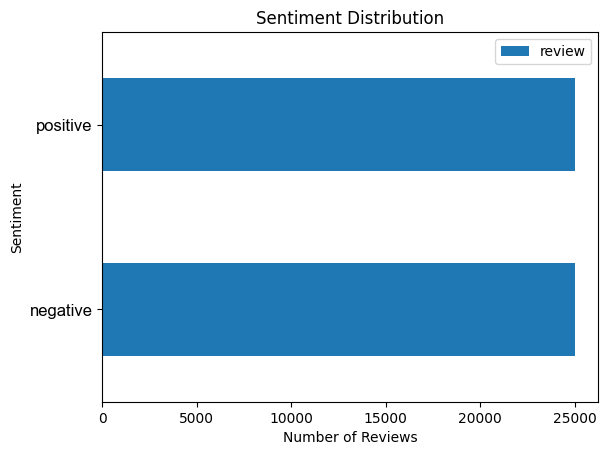

In [5]:
df.groupby(df['sentiment']).count().reset_index().plot(kind='barh', x='sentiment', y='review', title='Sentiment Distribution')
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution')
plt.yticks(rotation=0, fontsize=12, color='black', family='Arial')
plt.show()

## preprocessing
- removing HTML tags
- removing stop works, punctuations , special characters


In [6]:
#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data


In [7]:
#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

In [ ]:
# Load spaCy model once
nlp = spacy.load("en_core_web_sm")

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS
def preprocess(df):
    df['cleaned_review'] = df['review'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x: x.lower())
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x:  remove_emoji(x))
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x:  remove_url(x))
    # Remove extra spaces
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x: re.sub(r'\s+', ' ', x).strip()
    # Lemmatization using spaCy
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x: ' '.join([word.lemma_ for word in nlp(x) if word.lemma_ not in STOP_WORDS and word.is_alpha])) 

)
    return df

In [10]:
df2 = preprocess(df)

In [11]:
df2.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [12]:
df2['cleaned_review'].apply(lambda x: len(x.split())).describe()

count    50000.000000
mean       118.602820
std         89.270147
min          3.000000
25%         64.000000
50%         88.000000
75%        144.000000
max       1420.000000
Name: cleaned_review, dtype: float64

<Axes: title={'center': 'Length of Reviews'}, ylabel='Frequency'>

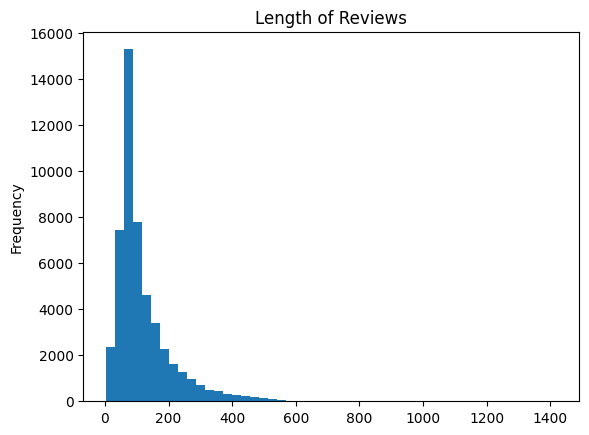

In [13]:
df2['cleaned_review'].apply(lambda x: len(x.split())).plot(kind='hist', bins=50, title='Length of Reviews')

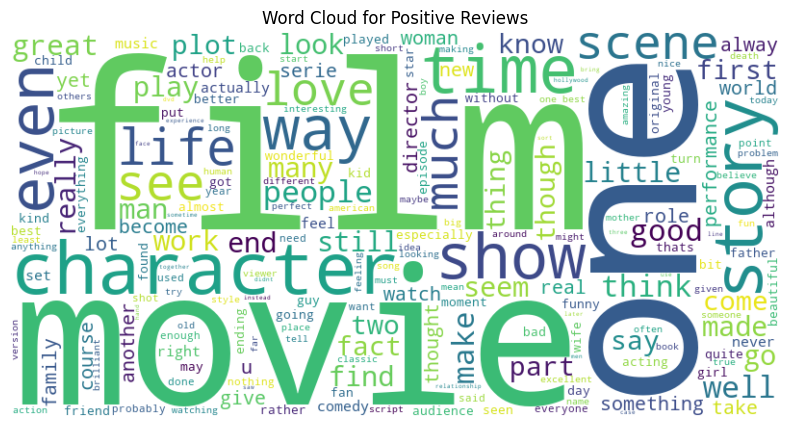

In [14]:
## word cloud for positive reviews
positive_reviews = df2[df2['sentiment'] == 'positive']['cleaned_review']
positive_text = ' '.join(positive_reviews)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

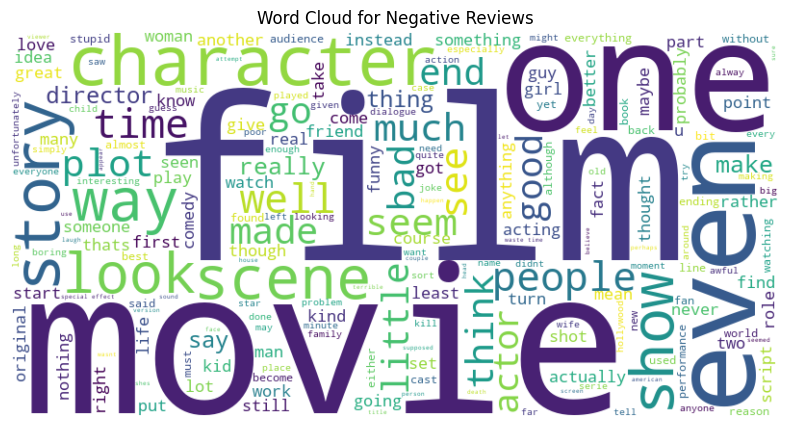

In [15]:
##word cloud for negative reviews
negative_reviews = df2[df2['sentiment'] == 'negative']['cleaned_review']
negative_text = ' '.join(negative_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


## Vectorization and Embeddings¶
Vectorizing allows us to convert data to higher dimensions. These vectorization strategies allow the word corpus to be properly suitable for advanced semantic analysis.

Here there are 2 variants of transforming the textual corpus to a numerical vector:

- Vectorize without semantics
- Retain Semantic Importance

In the first case, vectorization strategy is used to provide a co-occurence probabilistic distribution for vectorization. Methods like TF-IDF,Count vectorization/One hot vectorization, falls under this criteria.These methods leverage statistical co-occurence probabilities and log likelihoods for determining the frequently occuring sentences or group of words in a corpus.

The second case, relies on applying vectors with respect to semantic importance. Embeddings fall under this category. Embeddings are largely of 2 kinds


- **Static Embeddings** : `Word2Vec, Glove, Fasttext, Paragram
- **Dynamic Embeddings**: `ELMO, BERT & its variants, XLNet/Transformer-XL


All of these embeddings rely on pretrained word vectors where a probabilistic score is attributed to each word in the corpus. These probabilities are plotted in a low dimensional plane and the "meaning" of the words are inferred from these vectors. Generally speaking cosine distance is taken as the major metric of similarity measurement between word and sentence vectors to infer similarity.


## Vectorization - TFIDF and Count

**TF-IDF Vectorization**: This works by applying a logarithmic term to inverse document frequency (IDF) part other than determining the "TF" or term freqency part. 

**Count Vectorization**: This is a simpler vectorization technique which relies on frequency of occurence of a particular term in a document or corpus.



In [ ]:
#Count Vectorization
import matplotlib
import matplotlib.pyplot as plt
def vectorize(data):
    cv=CountVectorizer()
    fit_data_cv=cv.fit_transform(data)
    return fit_data_cv,cv

#Tfidf vectorization from sklearn
def tfidf(data):
    tfidfv=TfidfVectorizer()
    fit_data_tfidf=tfidfv.fit_transform(data)
    return fit_data_tfidf,tfidfv

In [24]:
## convert sentiment to numerical values using dict
sentiment_dict = {'positive': 1, 'negative': 0}
def sentiment_to_num(sentiment):
    return sentiment_dict[sentiment]
df2['sentiment_num'] = df2['sentiment'].apply(sentiment_to_num)


## Dimensionality reduction 
It is recommended to keep the tensors size small to allow for optimized calculations.
Decompostion techniques:
- PCA
- SVD
- TSNE

PCA algorithm rely on Eigen vector decomposition and Eigen matrices for creating smaller matrices.

TSNE is a more sophisticated method which uses a non convex optimization along with gradient descent. This is different than Eigen Vector (convex optimization) method of PCA and hence different results may be obtained in different iterations. It is a memory intensive method and is often powerful at the expense of longer execution time.

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches
def reduce_tfidf_dimensionality(X_tfidf, n_components=100):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_reduced = svd.fit_transform(X_tfidf)
    return X_reduced, svd

,review,sentiment,cleaned_review,sentiment_num
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,1


In [ ]:
X_tfidf, tfidf_vectorizer = tfidf(df2['cleaned_review'])  # from earlier
X_reduced, svd_model = reduce_tfidf_dimensionality(X_tfidf, n_components=100)

## Semantic Embeddings

**Word Embeddings**: These are vector space transformations of the words present in the corpus. When converted to vectors, several metrics can be applied like finding similarity, distance measurement between the vectors, numerical transforms of the vectors. With word vectors, we can specify semantic similarity between different words or collection of words.

We will be using `Word2Vec` Embeddings in this project and understand advanced BERT/GPT architecture.
- Word2Vec based on Heirarchical Softmax as well as with simplistic RNNs


In [ ]:
# # Splitting the dataset into training and testing sets
# X = df['cleaned_review']
# y = df['sentiment']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)


In [18]:
# ##splitting the reviews into words
# vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_test_vectorized = vectorizer.transform(X_test)

In [19]:
# ## vectorizing the text data
# vectorizer = CountVectorizer(max_features=5000)
# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_test_vectorized = vectorizer.transform(X_test)